<a id='contents'></a>

# Figures and analysis

This notebook contains scripts for producing the main figures and results accompanying the manuscript. Here we perform basic organization and processing of data, which is then passed to functions in figures.py (available at '/src' folder of this GitHub repository) for detailed formatting. The figures produced are stored as PDFs in the /figures folder.

## Contents

- [Overview and table of contents](#contents)
- [Loading libraries and global variables](#global)
- [Figures and data analysis](#figures)  
    - [Figure 1](#fig1)  
    - [Figure 2](#fig2)
    - [Figure 3](#fig3)
    - [Figure 4](#fig4)
    - [Figure 5](#fig5)
    - [Figure 6](#fig6)
    - [Figure 7](#fig7)
    - [Supplementary Figure 1](#figs1)
    - [Supplementary Figure 2](#figs2)
    - [Supplementary Figure 3](#figs3)
    - [Supplementary Figure 4](#figs4)

<a id='global'></a>

## Libraries and variables

In [101]:
# Full library list and version numbers

print('This notebook was prepared using:')

import sys, os
from copy import deepcopy
from importlib import reload
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy
import scipy.stats as stats
print('scipy version %s' % scipy.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

import figures as fig
reload(fig)

# GLOBAL VARIABLES

N = 1000        # number of sequences in the population
L = 50          # sequence length
T = 700         # number of generations
MU = 1e-3       # mutation rate
num_selections = 10  # number of sets of selection coefficients that we used
num_trials = 20  # for each set of selection coefficients, we simulated for 20 times
SAMPLE = [1000, 500, 100, 50, 10]  # sampling depth options when subsampling
RECORD = [1, 3, 5, 10]  # sampling time interval options when subsampling
LINEAR = [1, 5, 10, 20, 50, 100, 300]  # list of linear shrinkage strengths/sampling time intervals, e.g., interval=5, linear=5 ==> strength=25'
GAMMA = [5e-5, 5e-4, 5e-3, 5e-2, 5e-1, 1]  # non-linear shrinkage parameter choices that we tested
TRUNCATE = [200, 300, 400, 500, 600, 700]  # truncate options to test performance using different lengths of data
WINDOW = [0, 1, 2, 3, 4, 5, 10]  # window choices that we tested
# loss functions for non-linear shrinkage that we tested
LOSS = ['Fro | $\hat{C}-C$', 'Fro | $\hat{C}^{-1}-C^{-1}$', 'Fro | $C^{-1}\hat{C}-I$', 
        'Fro | $\hat{C}^{-1}C-I$', 'Fro | $\hat{C}^{-1/2}C\hat{C}^{-1/2}-I$', 
        'Nuc | $\hat{C}-C$', 'Nuc | $\hat{C}^{-1}-C^{-1}$', 'Nuc | $C^{-1}\hat{C}-I$', 
        'Nuc | $\hat{C}^{-1}C-I$', 'Nuc | $\hat{C}^{-1/2}C\hat{C}^{-1/2}-I$']

# GitHub directories
FIG_DIR = './figures'
HIV_DIR = 'data/HIV'
SELECTION_DIR = './src/selection'
INITIAL_DIR = './src/initial'
SIMULATION_OUTPUT_DIR = './data/simulation_output'
SUBSAMPLE_OUTPUT_DIR = './data/subsample_output'
ESTIMATION_OUTPUT_DIR = './data/estimation_output'
# Code Ocean directories
# HIV_DIR = '../data/HIV'
# SIM_DIR = '../data/simulation'

This notebook was prepared using:
python version 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.19.1
scipy version 1.5.2
pandas version 1.1.3
matplotlib version 3.3.2


<a id='figures'></a>

## Figures and data analysis

<a id='fig1'></a>

### Figure 1. Example estimation of integrated covariance matrix. 

In [36]:
def load_cov_example(s=5, n=0, tr=5, window=4):
    """Loads intgrated covariances with a certain data length and a certain window choice."""
    
    dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={TRUNCATE[tr]}_window={window}.npz')
    return dic['int_cov'][s, n], dic['int_dcov'][s, n]

In [37]:
true_cov, est_cov = load_cov_example(s=4, n=0, tr=5, window=4)

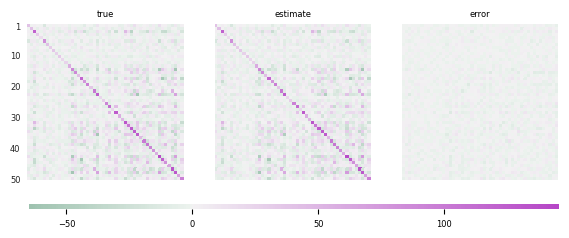

In [38]:
reload(fig)
fig.plot_figure_estimation_example(true_cov, est_cov, save_file=FIG_DIR + "/fig1-cov-heatmap.pdf")

<a id='fig2'></a>

### Figure 2. Example evolutionary path for a 50-site system.  

In [39]:
def load_selection(s):
    """Loads one of 10 sets of selection coefficients."""
    
    return np.load(SELECTION_DIR + f'/selection_{s}.npy')


def load_traj_example(s, n, p=0, q=0, tr=5):
    """Loads allele frequency trajectories of one particular simulation.
    
    Args:
        s: 0 ~ 9, indicating one of 10 sets of selection coefficients.
        n: 0 ~ 19, indicating one of 20 trials.
        p: 0 ~ 4, indicating one of 5 sampling depths.
        q: 0 ~ 3, indicating one of 3 sampling time intervals.
        tr: 0 ~ 5, indicating one of 6 truncating lengths.
    """
    
    if p == 0 and q == 0:
        dic = np.load(SIMULATION_OUTPUT_DIR + f'/simulation_output_s={s}_n={n}.npz')
    else:
        dic = np.load(SUBSAMPLE_OUTPUT_DIR + f'/subsample_output_s={s}_n={n}_sample={SAMPLE[p]}_record={RECORD[q]}.npz')
    traj = dic['traj'][:TRUNCATE[tr] + 1]
    return traj


In [40]:
s, n = 4, 0
traj = load_traj_example(s, n)
selection = load_selection(s)

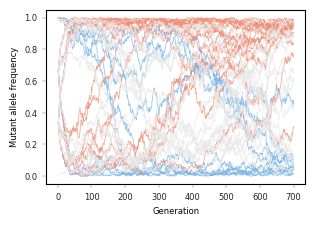

In [41]:
reload(fig)
fig.plot_figure_traj_example(traj, selection, save_file=FIG_DIR + "/fig2-frequency-trajectory.pdf")

<a id='fig3'></a>

### Figure 3. Performance comparison with ample data. 

In [104]:
def load_performance(window=4):
    """Loads spearmanr & error of inferred selections with a certain window choice."""
    
    # SL, MPL, est & est(uncalibrated)
    num_basic = 4
    spearmanr_basic = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)
    error_basic = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)

    # linear shrinkage on covariance
    spearmanr_linear = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)
    error_linear = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)

    # non-linear shrinkage on correlation
    spearmanr_dcorr = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    error_dcorr = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    
    for tr, truncate in enumerate(TRUNCATE):
        dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={truncate}_window={window}.npz')
        spearmanr_basic[tr] = dic['spearmanr_basic']
        spearmanr_linear[tr] = dic['spearmanr_linear']
        spearmanr_dcorr[tr] = dic['spearmanr_dcorr']
        error_basic[tr] = dic['error_basic']
        error_linear[tr] = dic['error_linear']
        error_dcorr[tr] = dic['error_dcorr']

    return (spearmanr_basic, spearmanr_linear, spearmanr_dcorr,
            error_basic, error_linear, error_dcorr)

In [105]:
(spearmanr_basic, spearmanr_linear, spearmanr_dcorr,
 error_basic, error_linear, error_dcorr) = load_performance(window=4)

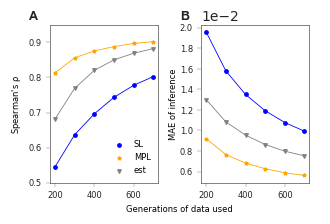

In [106]:
reload(fig)
fig.plot_figure_performance_with_ample_data(spearmanr_basic, error_basic, truncate_list=TRUNCATE, 
                                            save_file=FIG_DIR + "/fig3-performance-ample-data.pdf")

<a id='fig4'></a>

### Figure 4. Performance comparison with limited data.

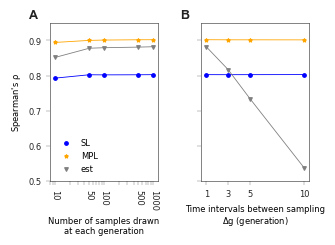

In [107]:
# Use loaded data in previous section plotting Fig. 3
reload(fig)
fig.plot_figure_performance_with_limited_data(spearmanr_basic, truncate_index=5, truncate_list=TRUNCATE, 
                                              sample_list=SAMPLE, record_list=RECORD, 
                                              save_file=FIG_DIR + "/fig4-performance-limited-data.pdf")

<a id='fig5'></a>

### Figure 5. Performance with linear shrinkage.

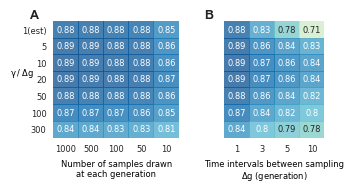

In [69]:
reload(fig)
fig.plot_figure_performance_with_linear_shrinkage(spearmanr_basic, spearmanr_linear, truncate_index=5, 
                                                  truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
                                                  linear_list=LINEAR, 
                                                  save_file=FIG_DIR + "/fig5-performance-linear-shrinkage.pdf")

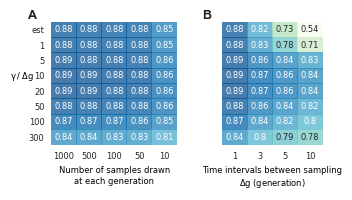

In [111]:
reload(fig)
fig.plot_figure_performance_with_linear_shrinkage(spearmanr_basic, spearmanr_linear, truncate_index=5, 
                                                  truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
                                                  linear_list=LINEAR, 
                                                  save_file=FIG_DIR + "/fig5-performance-linear-shrinkage.pdf")

<a id='fig6'></a>

### Figure 6. Performance with non-linear shrinkage on correlation matrix.

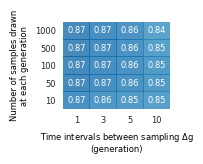

In [47]:
reload(fig)
fig.plot_figure_performance_with_nonlinear_shrinkage(spearmanr_dcorr, truncate_index=5, truncate_list=TRUNCATE, 
                                                     sample_list=SAMPLE, record_list=RECORD, loss_selected=3, 
                                                     gamma_selected=0, 
                                                     save_file=FIG_DIR + "/fig6-performance-nonlinear-shrinkage.pdf")

<a id='fig7'></a>

### Figure 7. Performance combining multiple replicates.

In [91]:
def load_performance_combine(window=4, loss_selected=3, gamma_selected=0):
    """Loads spearmanr & error of inferred selections by combining multiple replicates with a certain window choice."""
    
    # SL, MPL, est & est(uncalibrated)
    num_basic = 4
    spearmanr_basic_combine = np.zeros((len(TRUNCATE), num_selections, len(SAMPLE), len(RECORD), num_basic), dtype=float)
    error_basic_combine = np.zeros((len(TRUNCATE), num_selections, len(SAMPLE), len(RECORD), num_basic), dtype=float)

    # linear shrinkage on covariance
    spearmanr_linear_combine = np.zeros((len(TRUNCATE), num_selections, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)
    error_linear_combine = np.zeros((len(TRUNCATE), num_selections, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)

    # non-linear shrinkage on correlation
    spearmanr_dcorr_combine = np.zeros((len(TRUNCATE), num_selections, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    error_dcorr_combine = np.zeros((len(TRUNCATE), num_selections, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    
    for tr, truncate in enumerate(TRUNCATE):
        dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={truncate}_window={window}.npz')
        spearmanr_basic_combine[tr] = dic['spearmanr_basic_combine']
        spearmanr_linear_combine[tr] = dic['spearmanr_linear_combine']
        spearmanr_dcorr_combine[tr] = dic['spearmanr_dcorr_combine']
        error_basic_combine[tr] = dic['error_basic_combine']
        error_linear_combine[tr] = dic['error_linear_combine']
        error_dcorr_combine[tr] = dic['error_dcorr_combine']

    return (spearmanr_basic_combine, spearmanr_linear_combine, spearmanr_dcorr_combine,
            error_basic_combine, error_linear_combine, error_dcorr_combine)

In [92]:
(spearmanr_basic_combine, spearmanr_linear_combine, spearmanr_dcorr_combine,
 error_basic_combine, error_linear_combine, error_dcorr_combine) = load_performance_combine(window=4)

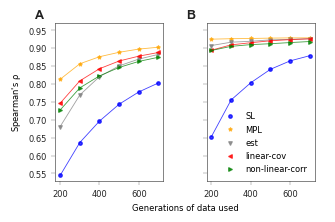

In [112]:
reload(fig)
fig.plot_figure_performance_combining_multiple_replicates(spearmanr_basic, spearmanr_linear, spearmanr_dcorr, 
                                                          spearmanr_basic_combine, spearmanr_linear_combine, 
                                                          spearmanr_dcorr_combine, truncate_list=TRUNCATE, 
                                                          sample_list=SAMPLE, record_list=RECORD, linear_selected=2, 
                                                          loss_selected=3, gamma_selected=0,
                                                          save_file=FIG_DIR + "/fig7-performance-combining-replicates.pdf")

<a id='figs1'></a>

### Supplementary Fig 1. 10 sets of selection coefficients used in simulations.

In [51]:
def load_selections():
    """Loads 10 sets of selection coefficients used in simulations."""
    
    selections = np.zeros((num_selections, L), dtype=float)
    for s in range(num_selections):
        selections[s] = np.load(SELECTION_DIR + f'/selection_{s}.npy')
    return selections

In [52]:
selections = load_selections()

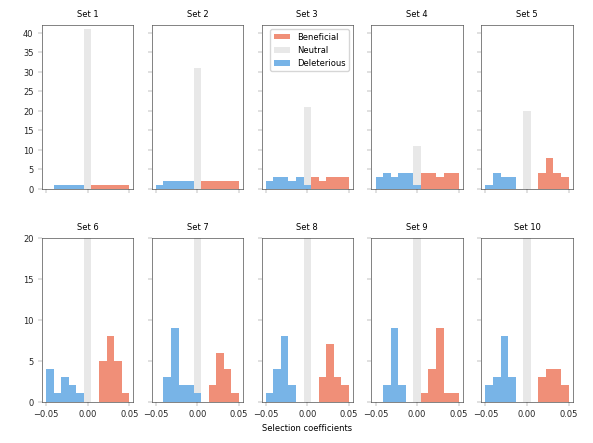

In [53]:
reload(fig)
fig.plot_supplementary_figure_selection(selections, alpha=1, save_file=FIG_DIR + "/figs1-selection-coefficients.pdf")

<a id='figs2'></a>

### Supplementary Fig 2.  Performance with different choices of time window under limited sampling effects.

In [94]:
def load_performance_window(truncate=700, linear_selected=2, loss_selected=3, gamma_selected=0):
    """Loads spearmanr & error of inferred selections with different time window choices."""
    
    # SL, MPL, est & est(uncalibrated)
    num_basic = 4
    spearmanr_basic_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)
    error_basic_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)

    # linear shrinkage on covariance
    spearmanr_linear_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)
    error_linear_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)

    # non-linear shrinkage on correlation
    spearmanr_dcorr_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)
    error_dcorr_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)
    
    for wi, window in enumerate(WINDOW):
        dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={truncate}_window={window}.npz')
        spearmanr_basic_window[wi] = dic['spearmanr_basic']
        spearmanr_linear_window[wi] = dic['spearmanr_linear'][:, :, :, :, linear_selected]
        spearmanr_dcorr_window[wi] = dic['spearmanr_dcorr'][:, :, :, :, loss_selected, gamma_selected]
        error_basic_window[wi] = dic['error_basic']
        error_linear_window[wi] = dic['error_linear'][:, :, :, :, linear_selected]
        error_dcorr_window[wi] = dic['error_dcorr'][:, :, :, :, loss_selected, gamma_selected]

    return (spearmanr_basic_window, spearmanr_linear_window, spearmanr_dcorr_window,
            error_basic_window, error_linear_window, error_dcorr_window)

In [95]:
(spearmanr_basic_window, spearmanr_linear_window, spearmanr_dcorr_window,
 error_basic_window, error_linear_window, error_dcorr_window) = load_performance_window(truncate=700,
                                                                                        linear_selected=2,
                                                                                        loss_selected=3, 
                                                                                        gamma_selected=0)

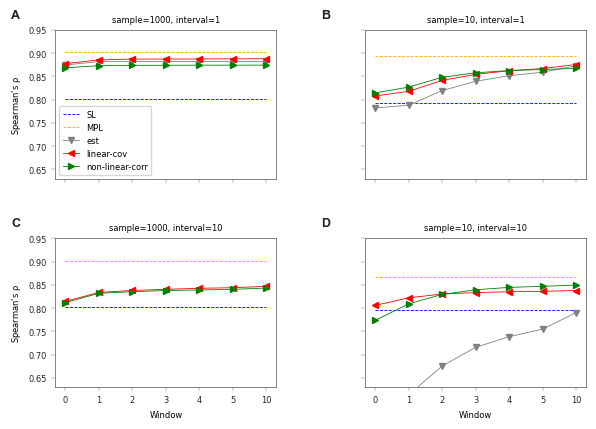

In [72]:
reload(fig)
fig.plot_supplementary_figure_performance_with_different_time_window(spearmanr_basic_window, spearmanr_linear_window, 
                                                                     spearmanr_dcorr_window, window_list=WINDOW,
                                                                     save_file=FIG_DIR + "/figs2-performance-time-window.pdf")

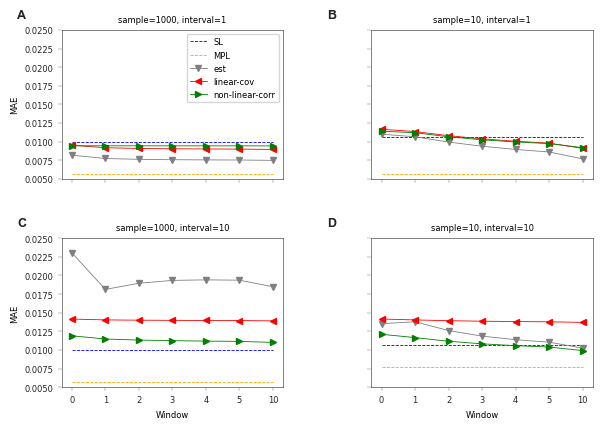

In [79]:
reload(fig)
fig.plot_supplementary_figure_performance_with_different_time_window(error_basic_window, error_linear_window, 
                                                                     error_dcorr_window, window_list=WINDOW, 
                                                                     ylim=(0.005, 0.025), ylabel='MAE',
                                                                     save_file=FIG_DIR + "/figs2-performance-time-window.pdf")

<a id='figs3'></a>

### Supplementary Fig 3.  Performance comparison with/without the calibration step. 

In [57]:
def load_cov_estimation_performance(window=4):
    """Loads spearmanr & error of estimated covariance with/without calibration."""
    
    true_cov = np.zeros((len(TRUNCATE), num_selections, num_trials, L, L), dtype=float)
    # est_cov[0] stores calibrated estimates; est_cov[1] stores uncalibrated estimates.
    est_cov = np.zeros((2, len(TRUNCATE), num_selections, num_trials, L, L), dtype=float)
    
    # Spearmanr between estimated and true covariance
    spearmanr_cov = np.zeros((len(TRUNCATE), num_selections, num_trials, 2), dtype=float)
    # Frobenious error of estimated covariance per generation
    error_cov = np.zeros((len(TRUNCATE), num_selections, num_trials, 2), dtype=float)
    
    for tr, truncate in enumerate(TRUNCATE):
        dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={truncate}_window={window}.npz')
        true_cov[tr] = dic['int_cov']
        est_cov[0][tr] = dic['int_dcov']
        est_cov[1][tr] = dic['int_dcov_uncalibrated']
        
        for s in range(num_selections):
            for n in range(num_trials):
                for i in [0, 1]:
                    spearmanr_cov[tr, s, n, i], _ = stats.spearmanr(np.ndarray.flatten(true_cov[tr, s, n]), 
                                                                 np.ndarray.flatten(est_cov[i, tr, s, n]))
                    error_cov[tr, s, n, i] = np.linalg.norm(est_cov[i, tr, s, n] - true_cov[tr, s, n]) / truncate

    return spearmanr_cov, error_cov

In [58]:
spearmanr_cov, error_cov = load_cov_estimation_performance(window=4)

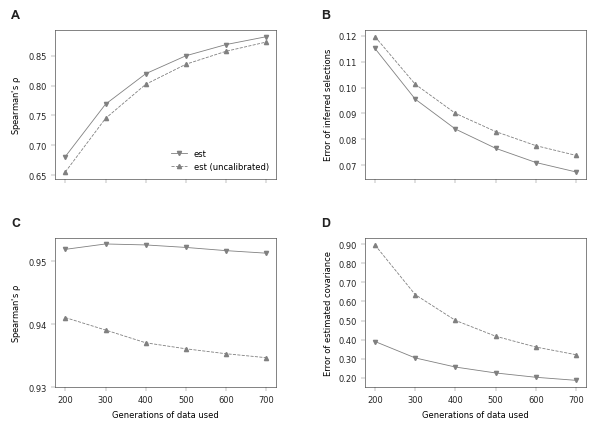

In [59]:
reload(fig)
fig.plot_supplementary_figure_performance_with_without_calibration(spearmanr_basic, error_basic, spearmanr_cov, 
                                                                   error_cov, truncate_list=TRUNCATE, 
                                                                   save_file=FIG_DIR + "/figs3-performance-calibration.pdf")

<a id='figs4'></a>

### Supplementary Fig 4.  Performance with different choices of gamma using different shrinkers.

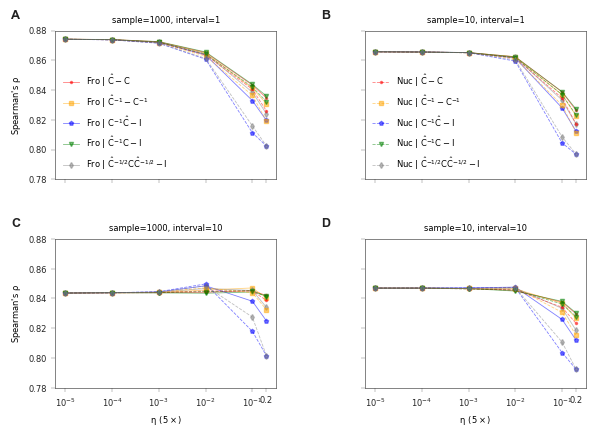

In [63]:
reload(fig)
fig.plot_supplementary_figure_performance_with_different_loss_gamma(spearmanr_dcorr, truncate_index=5,
                                                                    save_file=FIG_DIR + "/figs4-performance-gamma-loss.pdf")